# Libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import pickle
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D,Concatenate, Cropping2D, ZeroPadding2D
import tensorflow as tf
import random
import keras
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from IPython.display import clear_output
import matplotlib
seed = 2019
np.random.seed = seed
random.seed = seed
tf.seed = seed
path = '/home/karan/Desktop/Chandigarh_Police_Hackathon'


Using TensorFlow backend.


In [2]:
from IPython.display import Image

# Preprocessing

In [3]:
#image_id_list = train['image_id'].unique().tolist()
image_id_list = os.listdir(path+'/celeb_sketch')

In [4]:
#image_id_list = sum(image_id_list,[])
print(len(image_id_list),image_id_list)

202599 ['083201.jpg', '087532.jpg', '019237.jpg', '100218.jpg', '198961.jpg', '138025.jpg', '095602.jpg', '031081.jpg', '112294.jpg', '042974.jpg', '129554.jpg', '179292.jpg', '131166.jpg', '072701.jpg', '047063.jpg', '161969.jpg', '046851.jpg', '140937.jpg', '133528.jpg', '174353.jpg', '194200.jpg', '000681.jpg', '154489.jpg', '170204.jpg', '059868.jpg', '081216.jpg', '099630.jpg', '097308.jpg', '019388.jpg', '119220.jpg', '055982.jpg', '063238.jpg', '106197.jpg', '169559.jpg', '174892.jpg', '038012.jpg', '009335.jpg', '055601.jpg', '035098.jpg', '024518.jpg', '077223.jpg', '051967.jpg', '190727.jpg', '099779.jpg', '072257.jpg', '135911.jpg', '145890.jpg', '047455.jpg', '118950.jpg', '158539.jpg', '137867.jpg', '066064.jpg', '008080.jpg', '067259.jpg', '187303.jpg', '127212.jpg', '163523.jpg', '064732.jpg', '045847.jpg', '092639.jpg', '190120.jpg', '087196.jpg', '065976.jpg', '061241.jpg', '180309.jpg', '185487.jpg', '018693.jpg', '196435.jpg', '181037.jpg', '066068.jpg', '064122.jpg'

# Hyperparameters    
- image size
- train path
- epochs
- validation size
- Generator Declaration

In [5]:
image_size = (218,178)
train_path = '/home/karan/Desktop/Chandigarh_Police_Hackathon'
epochs = 30
validation_size = 16


# Utility Function

# Data Generator

In [6]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self,ids,filepath,batch_size=16,image_size=(480,640),channels=3):
        self.ids=ids
        self.filepath=filepath
        self.batch_size=batch_size
        self.image_size=image_size
        self.channels=channels
        
    def __len__(self):
            return (len(self.ids)//self.batch_size)
        
    '''def __load__(self,id_name):
            img = cv2.imread(filepath+'/'+id_name,-1)
            img = cv2.resize(img,(self.image_size[0],self.image_size[1]))
            return img'''
            
            
            
    def __getitem__(self,index):
            indexes = range(index*self.batch_size,index*self.batch_size+self.batch_size)
            
            ids_to_load = [self.ids[k] for k in indexes]
            X = self.__generate_x(ids_to_load)
            y = self.__generate_y(ids_to_load)
            l = []
            for i,m in enumerate(X):
                l.append(m.reshape(218,178,3))
            X = np.array(l)
            l = []
            for i,m in enumerate(y):
                l.append(m.reshape(218,178,3))
            y = np.array(l)
            return X,y
            
        
        
    def __generate_x(self,id_names):
            X = np.zeros((self.batch_size,self.image_size[0],self.image_size[1],self.channels))
            for i,id_n in enumerate(id_names):
                #print(self.filepath+'/sketch/'+id_n+'-sz1.jpg')
                img = cv2.imread(self.filepath+'/celeb_sketch/'+id_n)
                '''plt.imshow(img)
                plt.show()'''
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                
                img = img.astype(np.float32)/255.
                
                img = cv2.resize(img,(self.image_size[0],self.image_size[1]))
                '''plt.imshow(img)
                plt.show()'''
                X[i,:,:,:] = img.reshape(self.image_size[0],self.image_size[1],self.channels)
            return X
        
    def __generate_y(self,id_names):
            y = np.zeros((self.batch_size,self.image_size[0],self.image_size[1],self.channels))
            for i,id_n in enumerate(id_names):
                img = cv2.imread(self.filepath+'/celeb/'+id_n)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                img = img.astype(np.float32)/255.
                img = cv2.resize(img,(self.image_size[0],self.image_size[1]))
                '''plt.imshow(img)
                plt.show()'''
                y[i,:,:,:] = img.reshape(self.image_size[0],self.image_size[1],self.channels)
            return y
             
        
    ''' def __generate_y(self,id_names):
            y = np.zeros((self.batch_size,self.image_size[0],self.image_size[1],4))
            
            for i,id_n in enumerate(id_names):
                im_name = self.train[self.train['image_id'] == id_n]
                rles = im_name['EncodedPixels'].values
                #print(rles,np.array(rles).shape)
                y[i,:,:,:] = build_masks(rles,(1400,2100),reshape=(self.image_size[0],self.image_size[1]))
            
            return y'''
        
        
        

# Sample plot of data

In [7]:
train_gen = DataGenerator(image_id_list[:int(len(image_id_list)*0.2)],train_path,batch_size=16,image_size=(178,218),channels=3)
val_gen = DataGenerator(image_id_list[int(len(image_id_list)*0.95):],train_path,batch_size=16,image_size=(178,218),channels=3)
test_gen = DataGenerator(image_id_list[int(len(image_id_list)*0.25):int(len(image_id_list)*0.90)],train_path,batch_size=16,image_size=(178,218),channels=3)

In [8]:

X,y = val_gen.__getitem__(1)
val_gen.__len__()
#train_gen.__len__()

633

In [9]:
len(image_id_list)

202599

In [10]:
cv2.imwrite('file.jpg',X[1]*255.)

True

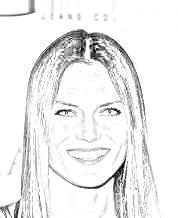

In [11]:
Image(filename='file.jpg')

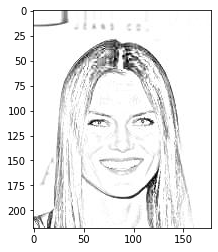

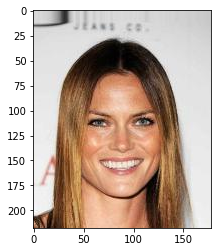

In [12]:
plt.imshow(X[1])
plt.show()
plt.imshow(y[1])
plt.show()

# Loss Function

In [13]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

# Different Convolution block

In [14]:
def get_crop_shape(target, refer):
        # width, the 3rd dimension
        cw = (target.get_shape()[2] - refer.get_shape()[2]).value
        assert (cw >= 0)
        if cw % 2 != 0:
            cw1, cw2 = int(cw/2), int(cw/2) + 1
        else:
            cw1, cw2 = int(cw/2), int(cw/2)
        # height, the 2nd dimension
        ch = (target.get_shape()[1] - refer.get_shape()[1]).value
        assert (ch >= 0)
        if ch % 2 != 0:
            ch1, ch2 = int(ch/2), int(ch/2) + 1
        else:
            ch1, ch2 = int(ch/2), int(ch/2)

        return (ch1, ch2), (cw1, cw2)





def down_block(x,filters,kernel_size=(3,3),strides=1,padding='same',activation='relu'):
    c = Conv2D(filters,kernel_size=kernel_size,padding=padding,strides=strides,activation=activation)(x)
    c = Conv2D(filters,kernel_size=kernel_size,padding=padding,strides=strides,activation=activation)(c)
    p = MaxPooling2D((2,2))(c)
    return c,p

def up_block(x,skip,filters,kernel_size=(3,3),strides=1,padding='same',activation='relu'):
    us = UpSampling2D((2,2))(x)
    ch, cw = get_crop_shape(skip,us)
    us = ZeroPadding2D(padding = (ch,cw))(us)
    #ch, cw = get_crop_shape(skip,us)
    #skip = Cropping2D(cropping=(ch,cw))(skip)
    us = Concatenate()([us,skip])
    us = Conv2D(filters,kernel_size,padding=padding,strides=strides,activation=activation)(us)
    us = Conv2D(filters,kernel_size,padding=padding,strides=strides,activation=activation)(us)
    return us
    
def bottleneck(x,filters,kernel_size=(3,3),strides=1,padding='same',activation='relu'):
    b = Conv2D(filters,kernel_size,padding=padding,strides=strides,activation=activation)(x)
    b = Conv2D(filters,kernel_size,padding=padding,strides=strides,activation=activation)(b)
    return b

# Unet Model

In [21]:
def Unet():
    f = [16,32,64,128,256]
    inputs = Input((image_size[0],image_size[1],3))
    
    c1,p1 = down_block(inputs,f[0])#350->175, 525->262
    c2,p2 = down_block(p1,f[1])#175->87, 262-> 131
    c3,p3 = down_block(p2,f[2])#87->43, 131 -> 65 
    c4,p4 = down_block(p3,f[3])#43->21, 65->32
    b = bottleneck(p4,f[4])#21,32
    u1 = up_block(b,c4,f[3])#
    u2 = up_block(u1,c3,f[2])#16->32
    u3 = up_block(u2,c2,f[1])#32->64
    u4 = up_block(u3,c1,f[0])#64->128
    
    outputs = Conv2D(3,(1,1),padding='same',activation='sigmoid')(u4)
    
    model = Model(inputs,outputs)
    
    return model
    

# Training the Model

In [22]:
model = Unet()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[dice_loss])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 218, 178, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 218, 178, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 218, 178, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 109, 89, 16)  0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [54]:
for i in range(train_gen.__len__()):
    X,y = train_gen.__getitem__(i)
    loss = model.train_on_batch(X,y)
    print('loss:',loss)
    val_x,val_y = val_gen.__getitem__(i)
    pred_y = model.predict(val_x)
    plt.imshow(pred_y[0])
    plt.title('Predicted')
    plt.show()
    plt.imshow(val_y[0])
    plt.title('Expected')
    plt.show()
    #clear_output(wait=True)
#model.fit_generator(train_gen,epochs = epochs,validation_data = val_gen)

KeyboardInterrupt: 

In [22]:
checkpoint = ModelCheckpoint('model.h5', save_best_only=True)
checkpoint2 = ModelCheckpoint("best_model.hdf5", monitor='loss', verbose=1,save_weights_only =True,
    save_best_only=True, mode='auto', period=1)
history = model.fit_generator(train_gen,epochs = epochs,validation_data = val_gen,callbacks=[checkpoint2,checkpoint])
with open('history.pickle','wb') as file:
    pickle.dump(history.history,file)

Epoch 1/30
2532/2532 [==============================] - 697s 275ms/step - loss: 0.5088 - dice_loss: 0.3887 - val_loss: 0.5240 - val_dice_loss: 0.4057

Epoch 00001: loss improved from inf to 0.50879, saving model to best_model.hdf5
Epoch 2/30
2532/2532 [==============================] - 622s 246ms/step - loss: 0.5050 - dice_loss: 0.3857 - val_loss: 0.4995 - val_dice_loss: 0.3761

Epoch 00002: loss improved from 0.50879 to 0.50499, saving model to best_model.hdf5
Epoch 3/30
2532/2532 [==============================] - 623s 246ms/step - loss: 0.5002 - dice_loss: 0.3812 - val_loss: 0.4983 - val_dice_loss: 0.3754

Epoch 00003: loss improved from 0.50499 to 0.50018, saving model to best_model.hdf5
Epoch 4/30
2532/2532 [==============================] - 626s 247ms/step - loss: 0.4986 - dice_loss: 0.3797 - val_loss: 0.4982 - val_dice_loss: 0.3881

Epoch 00004: loss improved from 0.50018 to 0.49857, saving model to best_model.hdf5
Epoch 5/30
2532/2532 [==============================] - 625s 247

KeyboardInterrupt: 

# Testing the Model

In [107]:
img = cv2.imread('image.png')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(178,218))
img = img.astype(np.float32)/255.


In [102]:
def dodgeV2(image, mask):
    return cv2.divide(image, 255-mask, scale=256)

In [103]:
def burnV2(image, mask):
    return 255 - cv2.divide(255-image, 255-mask, scale=256)

In [108]:
#img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
#ret,thresh1 = cv2.adaptiveThreshold(img,0.60,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
img = cv2.threshold(img,0.6,1,cv2.THRESH_BINARY)[1]
'''img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray_inv = 255 - img_gray
img_blur = cv2.GaussianBlur(img_gray_inv, ksize=(21, 21),sigmaX=0, sigmaY=0)
img_blend = dodgeV2(img_gray, img_blur)
img = cv2.cvtColor(img_blend,cv2.COLOR_GRAY2RGB)'''

'img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)\nimg_gray_inv = 255 - img_gray\nimg_blur = cv2.GaussianBlur(img_gray_inv, ksize=(21, 21),sigmaX=0, sigmaY=0)\nimg_blend = dodgeV2(img_gray, img_blur)\nimg = cv2.cvtColor(img_blend,cv2.COLOR_GRAY2RGB)'

In [29]:
kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1, 9,-1],
                              [-1,-1,-1]])
sharpened = cv2.filter2D(img, -1, kernel_sharpening)
dst = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)


error: OpenCV(4.1.1) /io/opencv/modules/photo/src/denoising.cpp:178: error: (-5:Bad argument) Type of input image should be CV_8UC3 or CV_8UC4! in function 'fastNlMeansDenoisingColored'


In [98]:
img.shape

(218, 178, 3)

In [15]:
X,y = val_gen.__getitem__(7)

In [16]:
X.shape

(16, 218, 178, 3)

In [109]:
#y_pred = model.predict(X)
y_pred = model.predict(img.reshape(1,218,178,3))

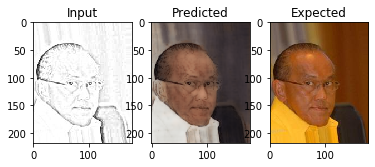

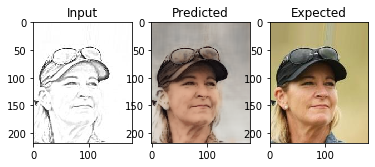

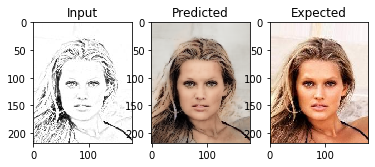

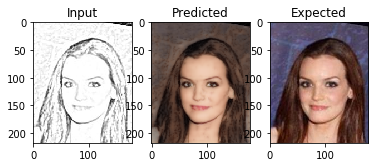

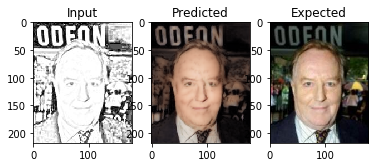

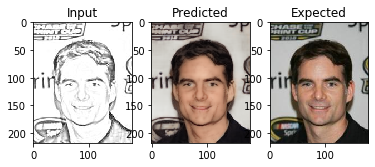

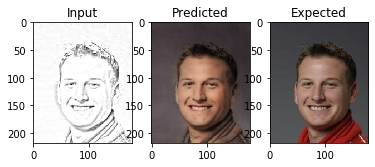

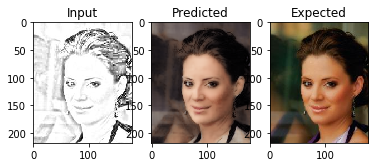

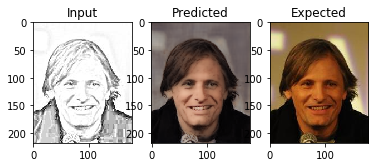

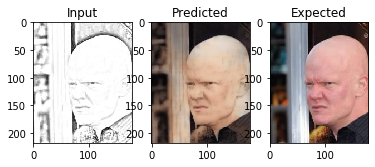

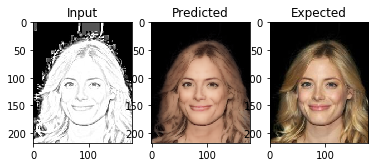

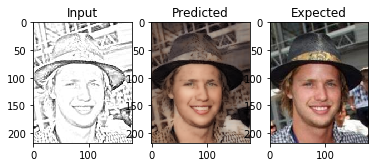

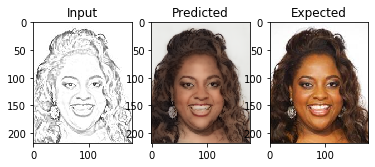

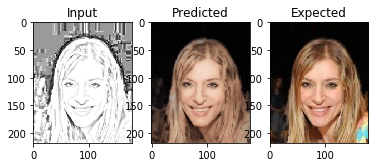

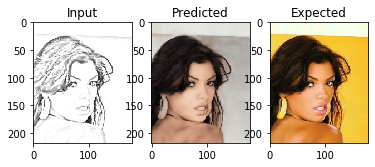

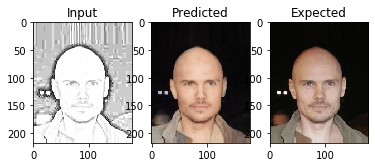

In [19]:
X,y = test_gen.__getitem__(7)
y_pred = model.predict(X)

for i in range(X.shape[0]):
    f,ax = plt.subplots(1,3)
    ax[0].imshow(X[i])
    ax[0].set_title('Input')
    ax[1].imshow(y_pred[i])
    ax[1].set_title('Predicted')
    ax[2].imshow(y[i])
    ax[2].set_title('Expected')
plt.show()



In [3]:
with open('history.pickle','rb') as file:
    history = pickle.load(file)

In [18]:
from keras.models import load_model
model = load_model('model.h5',custom_objects={'dice_loss':dice_loss})

# Image matching

In [50]:
max(img.flatten())

0.84313726

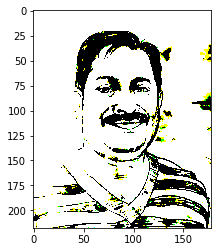

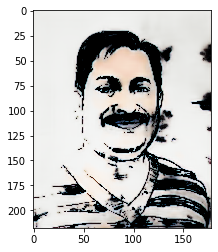

In [110]:

plt.imshow(img)
plt.show()
plt.imshow(y_pred.reshape(218,178,3))
plt.show()

In [23]:
matplotlib.image.imsave('mypic.png',y_pred)

ValueError: object too deep for desired array